# Twitter Sentiment Classifier | Logistic Regression
### Chatzispyrou Michail - 1115202000212

# Import essential libraries

In [1]:
import csv
import string
import emoji
import time
import optuna

import numpy as np
import pandas as pd


import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.model_selection import cross_validate, train_test_split, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from collections import Counter
from wordcloud import WordCloud

import unicodedata
from unidecode import unidecode

from tabulate import tabulate
import spacy
!python -m spacy download el_core_news_lg --quiet
nlp = spacy.load("el_core_news_lg")

✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_lg')


# Paths
We are defening some basic paths to make our life easier when reading or writing a file

In [2]:
ROOT_PATH = "/kaggle/"
INPUT_PATH = ROOT_PATH + "input/ys19-2023-assignment-1/"
OUTPUT_PATH = ROOT_PATH + "working/"

# Plotting functions
Since we were asked to plot data multiple times I preferred to make functions which given the data, the labels and the title it will make the corresponding graph.

In [3]:
def countplot(data, labels, percent, show, sort, title):
    if sort is not None:
        ax = sns.countplot(x=data, order=data.value_counts().sort_values(ascending=True).index)
    else:
        ax = sns.countplot(x=data)
    if percent is not None:
        for i in ax.containers:
            heights = [p.get_height() for p in i]
            for p, height in zip(i, heights):
                percentage = (height / len(data)) * 100
                ax.annotate(f"{int(height)}",
                    (p.get_x() + p.get_width() / 2.0, height),
                    ha="center",
                    va="center",
                    xytext=(0, 5),
                    textcoords="offset points")
                ax.annotate(f"{percentage:.2f}%",
                    (p.get_x() + p.get_width() / 2.0, height),
                    ha="center",
                    va="center",
                    fontsize=9,
                    xytext=(0, -11),
                    textcoords="offset points")
    else:
        for i in ax.containers:
            ax.bar_label(i,)
    if len(labels) == 2:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    else:
        plt.ylabel(labels[0])
    plt.title(title)
    if show:
        plt.show()

def stackedcountplot(data, labels, x, hue, show, sort, title):
    custom_pallete = {"POSITIVE": "Green", "NEGATIVE": "red", "NEUTRAL": "gray"}
    if sort is not None:
        ax = sns.countplot(data=data, x=x, hue=hue, order=data[x].value_counts().sort_values(ascending=True).index,
                     palette=custom_pallete)
    else:
        ax = sns.countplot(data=data, x=x, hue=hue, palette=custom_pallete)
    
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',(p.get_x() + p.get_width() / 2., height),fontsize = 7,ha='center',va='bottom') 
    
    if len(labels) == 2:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    else:
        plt.ylabel(labels[0])
    plt.title(title)
    if show:
        plt.show()
        
def bar_chart(data, show, title, labels):
    fig, ax = plt.subplots()
    sns.barplot(x=labels, y=data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
    ax.set_title(title)
    # Add numbers on top of the bars
    if title == "Time Taken":
        for i, val in enumerate(data):
            ax.text(i, val, val, ha='center', va='bottom', fontsize=9)
    else:
        for i, val in enumerate(data):
            ax.text(i, val, f"{val*100:.2f}%", ha='center', va='bottom', fontsize=9)
    if show:
        plt.show()

def custom_roc_curve(Y_val, y_score, classes, show):
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i, label in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(Y_val == label, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve {classes[i]} (AUC = {roc_auc[i]*100:0.2f}%)')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    if show:
        plt.show()

def custom_learning_curve(train_score, test_score, size, show):
    plt.title("Learning Curve")
    plt.plot(size, train_score, 'o-', color="r", label="Training")
    plt.plot(size, test_score, 'o-', color="g", label="Validation")
    plt.legend(loc="best")
    plt.ylabel("Score")
    plt.xlabel("Training Examples")
    if show:
        plt.show()

def custom_confusion_matrix(conf_matrix, classes, show):
    # Generate and print confusion matrix  
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = classes)
    cm_display.plot(ax=plt.gca())
    plt.grid(False)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.title("Confusion Matrix")
    if show:
        plt.show()

# Loading the Dataset
We are going to load the datasets

In [4]:
# csv -> dataframe
# I know I load them twice but it is helpfull later on
df_train = pd.read_csv(INPUT_PATH + "train_set.csv")
df_val = pd.read_csv(INPUT_PATH + "valid_set.csv")

df_train_np = pd.read_csv(INPUT_PATH + "train_set.csv")
df_val_np = pd.read_csv(INPUT_PATH + "valid_set.csv")

# Exploring the Dataset
We are going to examine the structure of the datasets in order to gain valuable insights about the data

## Firstly, we are going to check the form of the data and its content

In [5]:
# print the data frame
df_train_np

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είνα...,NEUTRAL,SYRIZA
...,...,...,...,...
36625,35374,@KourtakisJohn @kmitsotakis Ο Κούλης ο Μητσοτά...,NEUTRAL,ND
36626,7744,@enikos_gr @NChatzinikolaou @AdonisGeorgiadi Π...,NEGATIVE,ND
36627,35216,Η θέση του ΚΚΕ για την ασφάλεια των πολιτών κα...,NEUTRAL,KKE
36628,2855,@thanosplevris Μαρη κακομοίρα θυγατέρα του ναζ...,NEGATIVE,ND


We can see that the train set consists of the following 4 columns:
* ID $\rightarrow$ the ID of the tweet in the dataset
* Text $\rightarrow$ the text of the tweet
* Sentiment $\rightarrow$ the sentiment label POSITIVE, NEUTRAL or NEGATIVE
* Party $\rightarrow$ the potilical party the tweet is reffering to
Finally, we can see that the number of data which will be used to train our model is 36630

## We continue the examination by visualizing the number of tweets for every political party and also the number of each sentiment label for the corresponding political party

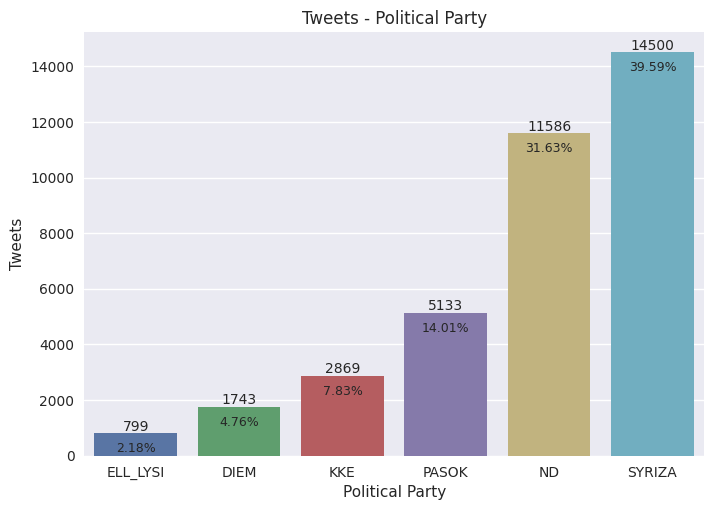

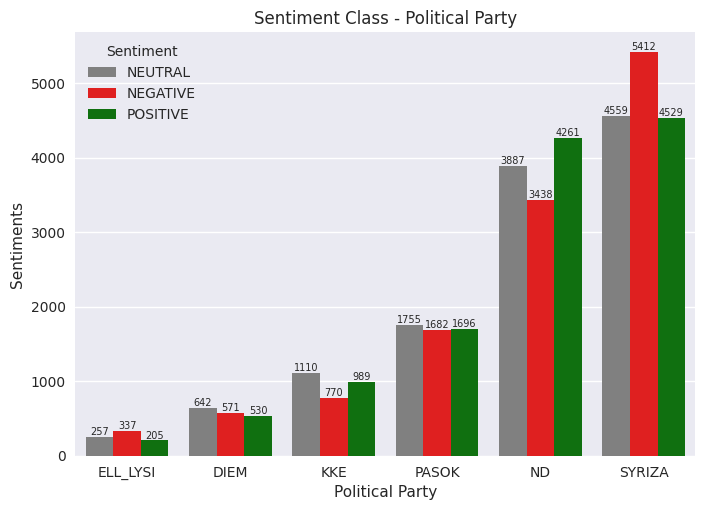

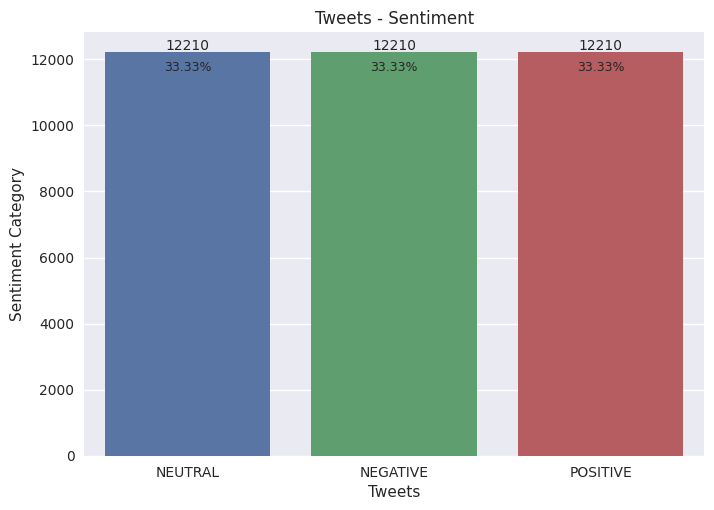

In [6]:
# Get the unique values for party
unique_values = df_train_np["Party"].unique()
# Find for each unique value their occurence
occurences = df_train_np["Party"].value_counts()[unique_values]
# Make a countplot
countplot(df_train_np["Party"], ["Political Party","Tweets"], True, True, True, "Tweets - Political Party")
# Make the stacked countplot
stackedcountplot(df_train_np, ["Political Party","Sentiments"], "Party", "Sentiment", True, True, "Sentiment Class - Political Party")
# Get the unique values for sentiment
unique_values = df_train_np["Sentiment"].unique()
# Find for each unique value their occurence
occurences = df_train_np["Sentiment"].value_counts()[unique_values]
countplot(df_train_np["Sentiment"], ["Tweets","Sentiment Category"], True, True, None, "Tweets - Sentiment")

Having thoroughly examined the dataset, we can now draw the following conclusions:
* The dataset is evenly distributed in terms of sentiment categories: </br></br>
&nbsp;&nbsp;12210 are NATURAL</br>
&nbsp;&nbsp;12210 are NEGATIVE</br>
&nbsp;&nbsp;12210 are POSITIVE</br></br>
* 39.59% of the tweets are reffering to "SYRIZA" in which:</br></br>
&nbsp;&nbsp;4559 are NATURAL</br>
&nbsp;&nbsp;5412 are NEGATIVE</br>
&nbsp;&nbsp;4529 are POSITIVE</br></br>
* 31.63% of the tweets are reffering to "ND" from which:</br></br>
&nbsp;&nbsp;3887 are NATURAL</br>
&nbsp;&nbsp;3438 are NEGATIVE</br>
&nbsp;&nbsp;4261 are POSITIVE</br></br>
* 14.01% of the tweets are reffering to "PASOK" from which:</br></br>
&nbsp;&nbsp;1755 are NATURAL</br>
&nbsp;&nbsp;1682 are NEGATIVE</br>
&nbsp;&nbsp;1696 are POSITIVE</br></br>
*  7.83% of the tweets are reffering to "KKE" from which:</br></br>
&nbsp;&nbsp;1110 are NATURAL</br>
&nbsp;&nbsp;770 are NEGATIVE</br> 
&nbsp;&nbsp;989 are POSITIVE</br></br>
*  4.76% of the tweets are reffering to "DIEM" from which:</br></br>
&nbsp;&nbsp;642 are NATURAL</br>
&nbsp;&nbsp;571 are NEGATIVE</br>
&nbsp;&nbsp;530 are POSITIVE</br></br>
*  2.18% of the tweets are reffering to "ELL_LYSI" from which:</br></br>
&nbsp;&nbsp;257 are NATURAL</br>
&nbsp;&nbsp;337 are NEGATIVE</br>
&nbsp;&nbsp;205 are POSITIVE

### We could also examine the validation set but we already know that it is the same as train set. On the other hand,  the test set does not containt the sentiment column, that's because the main purpose of this notebook is to predict their sentiment class using the train & validation sets.

# Data Pre-processing

## Data cleaning
Before diving into the vectorisers we need to clean up our dataset.


The dataset is difficult to pre-process due to the Greek texts it contains, in order to make the most of it we are going to use the following combinations to find our best model:
* No Pre-processing at all
* Basic Pre-processing
* Basic Pre-processing & Lemmatization<br>

I know I skipped the stemming process. Unfortunately I found only one worth mentioning library [Greek-Stemmer](https://github.com/kpech21/Greek-Stemmer/blob/master/README.md) but due to its peculiarity of using the [Ellogon](https://www.ellogon.org/) POS tagging system it was not possible to dynamically find the POS of each word to call the stemmer correctly. I hope the effort is taken into account and no point is deducted. Finally, while we are pre-processing the data we are creating a new column named `Tokens` in which we are storing the tokens of each tweet in order to use them in [Word Clouds - Tokens Frequency](#word-clouds-tokens-frequency) section.

In [7]:
def remove_accents(word):
    ret =''.join(c for c in unicodedata.normalize('NFD', word) if unicodedata.category(c) != 'Mn')
    return ret

def clean_tweets(df, lemm):
    # That's the basic pre-processing    
    # Remove possible links starting with http/https/www
    df['Text'] = df['Text'].str.replace(r"(http[s]?://|www\.)[^\s]+", " ", regex = True)
    # Remove whole word with # symbol
    df['Text'] = df['Text'].str.replace(r"(#)[^\s]+", " ", regex = True)
    # Remove whole word with @ symbol
    df['Text'] = df['Text'].str.replace(r"(@)[^\s]+", " ", regex = True)
    # Lowercase everything
    df['Text'] = df['Text'].str.lower()
    # Keep only latin/greek letters and numbers
    df['Text'] = df['Text'].str.replace(r"[^\wa-zα-ω]", " ", regex = True)    
    # If the user wants to do the lemmazation process we will perform it otherwise the token will be added only if it is not a stop word
    df['Tokens'] = df['Text'].apply(lambda text: [token.lemma_ if lemm else token.text for token in nlp(remove_accents(text)) if token.text not in nlp.Defaults.stop_words and token.text.strip()])
    # At last we are combine the tokens to create the new text for the tweet    
    df['Text'] = df['Tokens'].apply(lambda tokens: " ".join(tokens))
    # Then return the cleaned dataframe
    return df

I'm adding two more stop words in the set and also remove the accents from the stop words.

In [8]:
for word in set(nlp.Defaults.stop_words):
    nlp.Defaults.stop_words.add(remove_accents(word))
nlp.Defaults.stop_words.add('κ')
nlp.Defaults.stop_words.add('κι')

#### The cell below has to run only one time in order for the pre-process to take place. After that we can just load any possible combination of the cleaned datasets that was mentioned above.

In [9]:
# This process needs to be done for both the train set and the validation set
for label in ["train", "val"]:
    # We are going to clean the datasets with all possible combinations
    for (name, args) in zip(["bp", "pl"], ["False", "True"]):
        # First we copy the dataframe
        exec(f"df_{label}_cleaned_{name} = df_{label}.copy()")
        # Now we will clean the text column
        exec(f"df_{label}_cleaned_{name} = clean_tweets(df_{label}_cleaned_{name}, {args})")
        # Save the cleaned dataset in case we need it in the future instead of cleaning it from the beginning
        exec(f"df_{label}_cleaned_{name}.to_json(OUTPUT_PATH + 'cleaned_{label}_{name}.json')")

# For the df_train_np and df_val_np we are going to create the Tokens column manually
# I used the nltk tokenization here because the spaCy was taking the whole link/mentions/hashtags
# Which was not helpfull for the word clouds
df_train_np['Tokens'] = df_train_np['Text'].apply(word_tokenize)
df_val_np['Tokens'] = df_val_np['Text'].apply(word_tokenize)

## Create features for the model - Vectorisers
Now that we have cleaned our dataset we are ready to compare the following vectorising methods:
* Count Vectorizer
* Hashing Vectorizer
* TF-IDF Vectorizer

In [10]:
  # Define the metrics we are going to use
  scoring = {
    'recall': make_scorer(recall_score, average='macro',zero_division = 0),
    'f1-score': make_scorer(f1_score, average='macro',zero_division = 0),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro',zero_division = 0)
  }

In [11]:
def show_score(message, t, r, f, a, p):
  # Print the classificaiton method
  print(message)
  # Print Time
  print(f"\tTime Taken: {t} ")
  # Print Precision
  print(f"\tPrecision: {p*100:.2f}%")
  # Print Recall
  print(f"\tRecall: {r*100:.2f}%")
  # Print F-Measure
  print(f"\tF1-Score: {f*100:.2f}%")
  # Print Accuracy
  print(f"\tAccuracy: {a*100:.2f}%\n")

In [12]:
# Create a function which will test all given vectorizers
def evaluate_vectorizers(train, val):
  # Split train and validation sets  
  X_train = train['Text']
  X_val = val['Text']
  Y_train = train['Sentiment']
  Y_val = val['Sentiment']
  # Define 3 lists each one to store the scores for the respective metric
  cv_scores = []
  tv_scores = []
  hv_scores = []
  # Define the vectorizer methods
  vectorizers = [CountVectorizer(),TfidfVectorizer(),HashingVectorizer()]
  # Loop for every method to evaluate and show
  for i, (vectorizer, message, storage) in enumerate(zip(vectorizers,["Count Vectorizer","TF-IDF Vectorizer","Hashing Vectorizer"],[cv_scores,tv_scores,hv_scores])):
    # Define classifier
    clf = LogisticRegression(max_iter=2000)
    
    # Begin timer    
    begin_timer = time.perf_counter()
    
    # For the train set we !fit_transform!
    X_train_vect = vectorizer.fit_transform(X_train)
    # On ther other hand for the validation set we only !transform!
    X_val_vect = vectorizer.transform(X_val)   
    clf.fit(X_train_vect, np.ravel(Y_train))
    scores = cross_validate(clf, X_val_vect, np.ravel(Y_val), cv=5, n_jobs = -1, scoring=scoring)
    
    # Stop timer
    stop_timer = time.perf_counter()
    
    # Calculate Time Taken
    time_taken = f"{stop_timer-begin_timer:.2f}"
    
    # Split the scores in variables
    recall_scores = scores['test_recall'].mean()
    f1_scores = scores['test_f1-score'].mean()
    accuracy_scores = scores['test_accuracy'].mean()
    precision_scores = scores['test_precision'].mean()
    # Add the scores in the corresponding list
    storage += [time_taken, recall_scores, f1_scores, accuracy_scores, precision_scores]
    # Show the results
    show_score(message, time_taken, recall_scores, f1_scores, accuracy_scores, precision_scores)
  # Return the lists
  return cv_scores, tv_scores, hv_scores

## No Pre-Processing - Vectorizers

In [13]:
cv_scores_np, tv_scores_np, hv_scores_np = evaluate_vectorizers(df_train_np, df_val_np)

Count Vectorizer
	Time Taken: 138.56 
	Precision: 37.82%
	Recall: 37.83%
	F1-Score: 37.77%
	Accuracy: 37.83%

TF-IDF Vectorizer
	Time Taken: 48.67 
	Precision: 39.16%
	Recall: 39.14%
	F1-Score: 39.12%
	Accuracy: 39.14%

Hashing Vectorizer
	Time Taken: 387.79 
	Precision: 38.78%
	Recall: 38.76%
	F1-Score: 38.70%
	Accuracy: 38.76%



## Basic Pre-Processing - Vectorizers

In [14]:
#Load the cleaned data for Basic Pre-Processing
df_train_bp = pd.read_json(OUTPUT_PATH + "cleaned_train_bp.json")
df_val_bp = pd.read_json(OUTPUT_PATH + "cleaned_val_bp.json")
cv_scores_bp, tv_scores_bp, hv_scores_bp = evaluate_vectorizers(df_train_bp, df_val_bp)

Count Vectorizer
	Time Taken: 37.28 
	Precision: 37.86%
	Recall: 37.81%
	F1-Score: 37.73%
	Accuracy: 37.81%

TF-IDF Vectorizer
	Time Taken: 26.87 
	Precision: 38.83%
	Recall: 38.82%
	F1-Score: 38.79%
	Accuracy: 38.82%

Hashing Vectorizer
	Time Taken: 323.95 
	Precision: 38.47%
	Recall: 38.47%
	F1-Score: 38.43%
	Accuracy: 38.47%



## Basic Pre-processing & Lemmatization - Vectorizers

In [15]:
#Load the cleaned data for Basic Pre-Processing
df_train_pl = pd.read_json(OUTPUT_PATH + "cleaned_train_pl.json")
df_val_pl = pd.read_json(OUTPUT_PATH + "cleaned_val_pl.json")
cv_scores_pl, tv_scores_pl, hv_scores_pl = evaluate_vectorizers(df_train_pl, df_val_pl)

Count Vectorizer
	Time Taken: 44.52 
	Precision: 37.91%
	Recall: 37.82%
	F1-Score: 37.76%
	Accuracy: 37.83%

TF-IDF Vectorizer
	Time Taken: 21.18 
	Precision: 37.85%
	Recall: 37.84%
	F1-Score: 37.83%
	Accuracy: 37.84%

Hashing Vectorizer
	Time Taken: 342.01 
	Precision: 37.51%
	Recall: 37.52%
	F1-Score: 37.49%
	Accuracy: 37.52%



## Results Vectorizers
We will gather the results from all executions and we will plot them in order to find the best one.<br>
We need to explain the following abbreviation:
* NP $\rightarrow$ No Pre-processing
* BP $\rightarrow$ Basic Pre-processing
* PL $\rightarrow$ Basic Pre-processing & Lemmatization

### Table Visualization

In [16]:
# Define the headers for the table
headers = ['', "Time Taken", "Recall", "F1-Score", "Accuracy", "Precision"]
# Define the generic score names
generic_scores = ["cv_scores", "tv_scores", "hv_scores"]
# Define the suffixies
suffixes = ["np", "bp", "pl"]
# Define the vectorizers
vectorizers_name = ["Count", "TF-IDF", "Hashing"]
# All the results
results = []
for suffix in suffixes:
    for (score, vectorizer) in zip(generic_scores, vectorizers_name):
        # For each combination calculate its value and append it to the list with all the results
        exec(f"results.append([\"{vectorizer}-{suffix.upper()}\"] + [val for val in {score}_{suffix}])")
# Display the table
print(tabulate(results, headers, tablefmt="fancy_grid"))

╒════════════╤══════════════╤══════════╤════════════╤════════════╤═════════════╕
│            │   Time Taken │   Recall │   F1-Score │   Accuracy │   Precision │
╞════════════╪══════════════╪══════════╪════════════╪════════════╪═════════════╡
│ Count-NP   │       138.56 │ 0.378259 │   0.377749 │   0.378252 │    0.378164 │
├────────────┼──────────────┼──────────┼────────────┼────────────┼─────────────┤
│ TF-IDF-NP  │        48.67 │ 0.391434 │   0.391172 │   0.391438 │    0.39164  │
├────────────┼──────────────┼──────────┼────────────┼────────────┼─────────────┤
│ Hashing-NP │       387.79 │ 0.387612 │   0.387042 │   0.387617 │    0.387832 │
├────────────┼──────────────┼──────────┼────────────┼────────────┼─────────────┤
│ Count-BP   │        37.28 │ 0.378058 │   0.377312 │   0.378057 │    0.378633 │
├────────────┼──────────────┼──────────┼────────────┼────────────┼─────────────┤
│ TF-IDF-BP  │        26.87 │ 0.388188 │   0.387867 │   0.38819  │    0.388275 │
├────────────┼──────────────

### Barplot Visualization

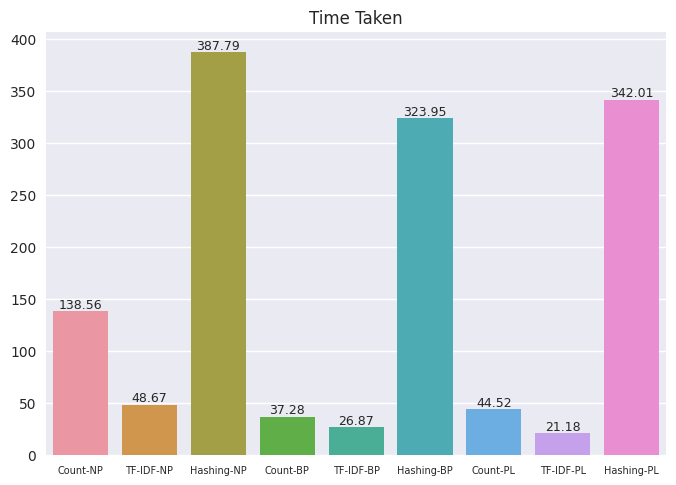

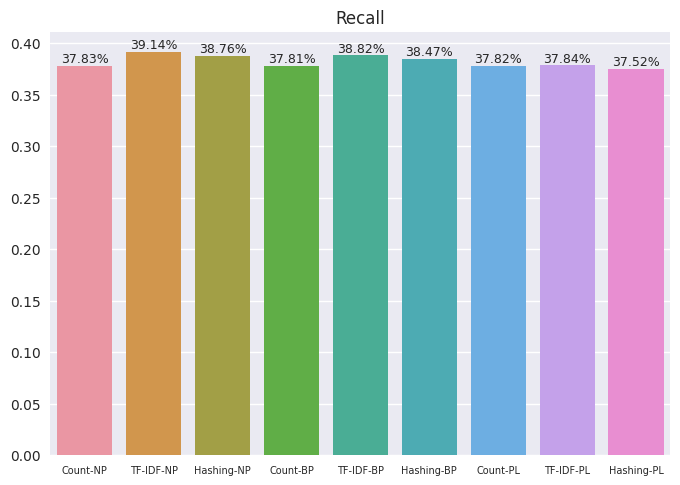

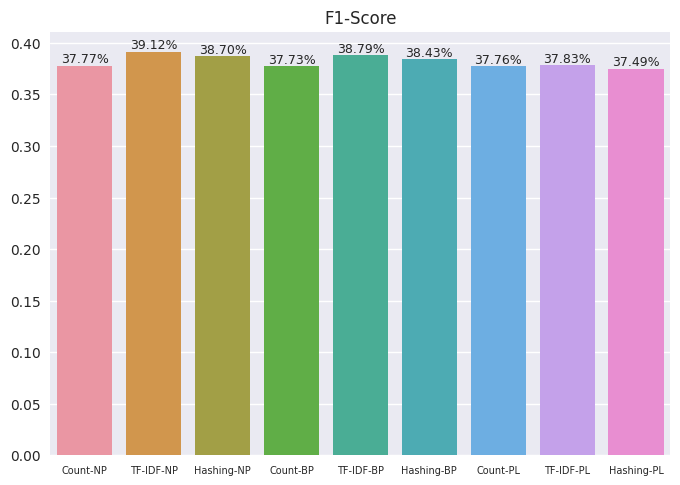

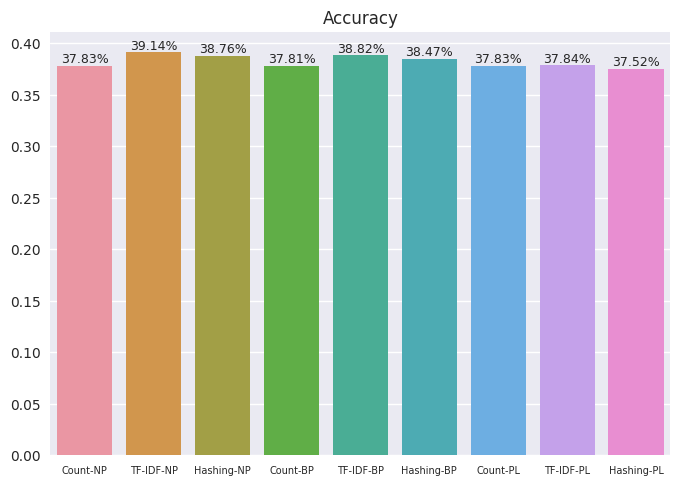

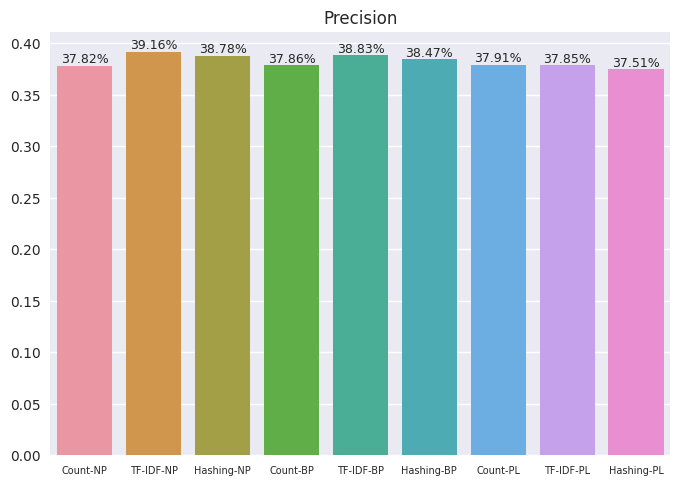

In [17]:
# Define the generic score names
generic_scores = ["cv_scores", "tv_scores", "hv_scores"]
# Define the suffixies
suffixes = ["np", "bp", "pl"]
# Define the vectorizers
vectorizers_name = ["Count", "TF-IDF", "Hashing"]

# Define the list all combinations
combinations = []
# Define the lists that will hold the values for each category 
Time = []
recall = []
f1 = []
accuracy = []
precision = []

for suffix in suffixes:
    for (score, vectorizer) in zip(generic_scores, vectorizers_name):
        # Create and store the combination
        exec(f"combinations += [\"{vectorizer}-{suffix.upper()}\"]")
        # Now for this combination add its values to the total values in order to plot them
        for i, list_name in enumerate(["Time", "recall", "f1", "accuracy", "precision"]):
            exec(f"{list_name} += [{score}_{suffix}[{i}]]")

# For every category time, recall etc            
for list_name, title in zip(["Time", "recall", "f1", "accuracy", "precision"],["Time Taken", "Recall", "F1-Score", "Accuracy", "Precision"]):
    # Call a custom bar chart function
    exec(f"bar_chart([float(val) for val in {list_name}], True, \"{title}\", combinations)")

### Analysis
From the charts above it is obvious that the hashing vectorizer sacrifies time in order to achieve higher F1-Score. We can see that in every combination especially in the last one (basic pre-processing & lemmazation) which reached better score than TF-IDF but not as good as the basic preprocessing with TF-IDF one. We will ch

## Word Clouds - Tokens Frequency
Now that we have find the best combination of vectorizer & pre-processing to use, we are going to also visualize some other informations. For example, we are going to see the most frequenctly used words before and after pre-processing. Also, we are going to see a word cloud for each Sentiment Category (POSITIVE, NEUTRAL, NEGATIVE).

### To begin with, we can visualize the 3 different Texts through a dataframe

In [18]:
# Define suffixes
suffixes = ["np", "bp", "pl"]
# Create an empty dataframe in which we will store common words for each combination of processed (and not) data
df_most_used_words = pd.DataFrame()

for suffix in suffixes:
    # Get a list with the names     
    top_words = Counter([item for sublist in eval(f'df_train_{suffix}')['Tokens'] for item in sublist])
    df_most_used_words[f'Common-Words-{suffix.upper()}'], df_most_used_words[f'Count-{suffix.upper()}'] = zip(*top_words.most_common(20))

df_most_used_words.style.background_gradient(cmap='Blues')

,Common-Words-NP,Count-NP,Common-Words-BP,Count-BP,Common-Words-PL,Count-PL
0,:,36212,νδ,5620,τσιπρας,8662
1,#,34383,συριζα,4932,νδ,5619
2,https,25791,τσιπρα,4522,συριζα,4610
3,.,22585,μητσοτακης,4232,μητσοτακης,4222
4,",",21957,τσιπρας,4181,μητσοτακη,3796
5,@,17872,μητσοτακη,3786,κκε,2716
6,και,17413,κκε,2716,πασοκ,2055
7,το,15547,πασοκ,2058,κανω,1809
8,να,14973,κιναλ,1781,κιναλ,1781
9,του,14321,νεα,1334,αλεξη,1454


### But, we can also visualize them with word clouds

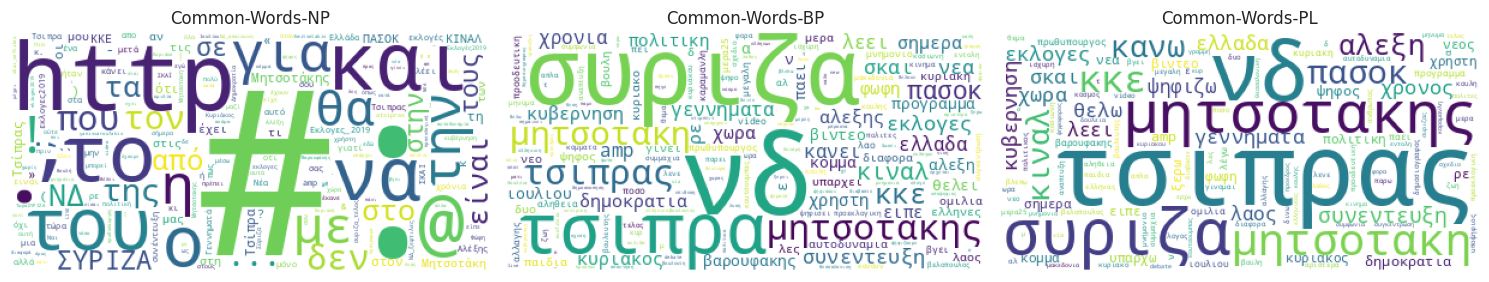

In [19]:
suffixes = ["np", "bp", "pl"]
fig, axes = plt.subplots(1, len(suffixes), figsize=(15, 5))
for i, suffix in enumerate(suffixes):
    tokenized_data = eval(f'df_train_{suffix}')['Tokens'].apply(lambda tokens: ' '.join(map(str, tokens)))
    # Generate Word Cloud
    wordcloud = WordCloud(background_color='white', collocations=False, stopwords=set(), regexp=r'\S+').generate('\n'.join(tokenized_data))
    # Plot the WordCloud image on the i-th subplot
    axes[i].imshow(wordcloud)
    axes[i].axis('off')
    axes[i].set_title(f"Common-Words-{suffix.upper()}")
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#### Analysis
Να γράψω κάποια πράγματα για τα 3 wordclouds και τα dataframe απο πανω

### Words per Sentiment Category
In order to watch the effects of the TF-IDF vectorizer and Basic Pre-Processing we are going to visualize the most common words in each category. We are also going to visualize No Pre-Processing per sentiment, this way we can draw conclusions about which words are mapped to each category that are affect our model to predict the sentiment category.

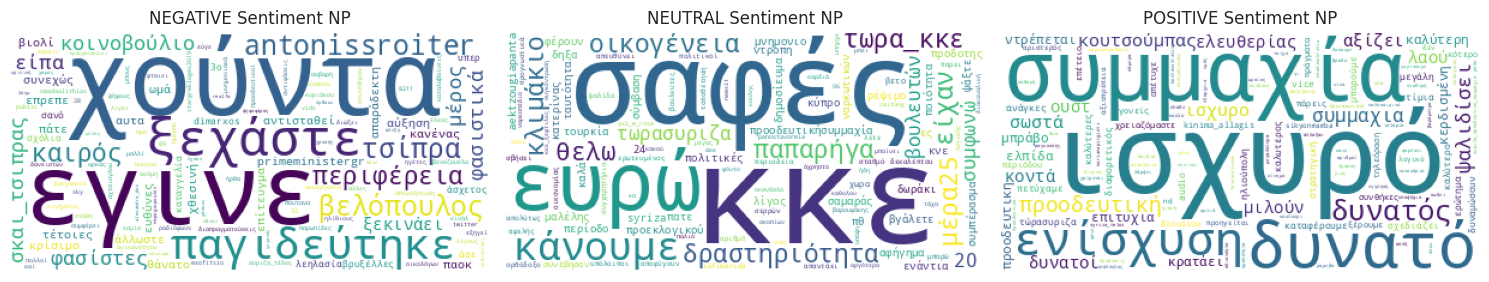

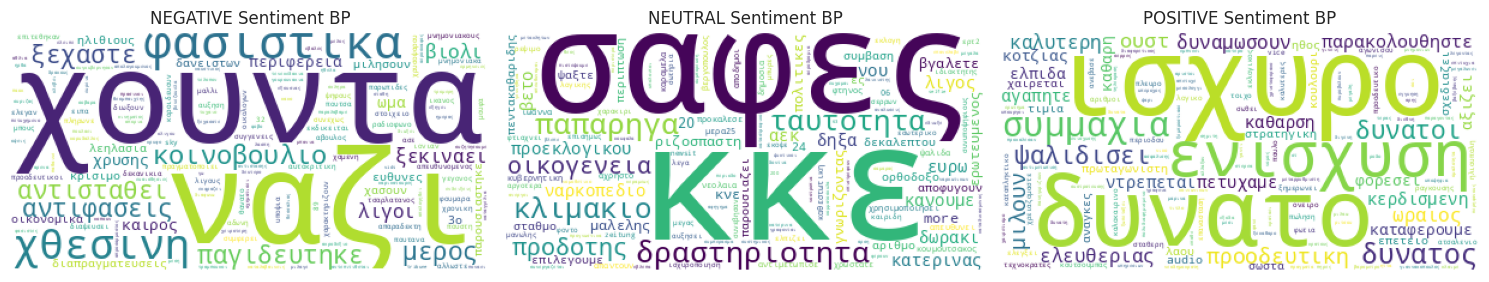

In [20]:
for suffix in ["np", "bp"]:
    exec(f'X_train = df_train_{suffix}[\'Text\']')
    exec(f'X_val = df_val_{suffix}[\'Text\']')
    exec(f'Y_train = df_train_{suffix}[\'Sentiment\']')
    exec(f'Y_val = df_val_{suffix}[\'Sentiment\']')

    # Define the vectorizer methods
    vectorizer = TfidfVectorizer()

    # Define classifier
    clf = LogisticRegression(max_iter=2000)

    # For the train set we !fit_transform!
    X_train_vect = vectorizer.fit_transform(X_train)

    # On ther other hand for the validation set we only !transform!
    X_val_vect = vectorizer.transform(X_val)   
    clf.fit(X_train_vect, np.ravel(Y_train))

    # Retrieve feature names and coefficients (weights)
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefficients = clf.coef_

    # Create Word Clouds for each sentiment using subplots
    sentiments = ["NEGATIVE", "NEUTRAL", "POSITIVE"]
    fig, axes = plt.subplots(1, len(sentiments), figsize=(15, 5))

    for i, sentiment in enumerate(sentiments):
        # For each Sentiment Label extract its words    
        sentiment_words_dict = {word: coefficients[i, feature_names == word][0] for word in feature_names}
        # Generate Word Cloud
        wordcloud = WordCloud(background_color='white').generate_from_frequencies(sentiment_words_dict)
        # Display the Word Cloud in a subplot
        axes[i].imshow(wordcloud)
        axes[i].axis("off")
        axes[i].set_title(f"{sentiment} Sentiment {suffix.upper()}")
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
    print()

#### Analysis
Να γράψω κάποια πράγματα για τα 3 wordclouds
It's obvious that there are some misplaced words like `ουστ` which in Greek dialect has a negative meaning but everything is expected due to the wrong labels in the dataset.

# Algorithms and Experiments
In this section we are going to try different solvers and penalties. For each trial we are going to plot and comment the learning curve.

In [21]:
def show_score_full(message, t, r, f, a, p):
  # Print the classificaiton method
  print(message)
  # Print Time
  print(f"\tTime Taken: {t} ")
  # Print Precision
  print(f"\tPrecision: {p}")
  # Print Recall
  print(f"\tRecall: {r}")
  # Print F-Measure
  print(f"\tF1-Score: {f}")
  # Print Accuracy
  print(f"\tAccuracy: {a}\n")

def evaluate_solvers_regularizers(train, val, solver, regularization, show, c=1):
    X_train = train['Text']
    X_val = val['Text']
    Y_train = train['Sentiment']
    Y_val = val['Sentiment']
   
    # Begin timer    
    begin_timer = time.perf_counter()

    # Define classifier
    if regularization == "elasticnet":
        clf = LogisticRegression(max_iter=2000, random_state=212, C=c, solver=solver, penalty=regularization, l1_ratio=0.5)
    else:
        clf = LogisticRegression(max_iter=2000, random_state=212, C=c, solver=solver, penalty=regularization)
    
    # Define vectorizer 
    vectorizer = TfidfVectorizer()

    # For the train set we !fit_transform!
    X_train_vect = vectorizer.fit_transform(X_train)
    # On ther other hand for the validation set we only !transform!
    X_val_vect = vectorizer.transform(X_val)   
    clf.fit(X_train_vect, np.ravel(Y_train))
    scores = cross_validate(clf, X_val_vect, np.ravel(Y_val), cv=5, n_jobs = -1, scoring=scoring)
    
    # Stop timer
    stop_timer = time.perf_counter()
    
    # Calculate Time Taken
    time_taken = f"{stop_timer-begin_timer:.2f}"
    
    # Split the scores in variables
    recall_scores = scores['test_recall'].mean()
    f1_scores = scores['test_f1-score'].mean()
    accuracy_scores = scores['test_accuracy'].mean()
    precision_scores = scores['test_precision'].mean()
    # Show the results
    if show:
        show_score_full(f"{solver.upper()} & {regularization.upper()} Regularization", time_taken, recall_scores, f1_scores, accuracy_scores, precision_scores)
    
    # Now we are going to calculate and plot the learning curve
    
    # Define the classifier again
    if regularization == "elasticnet":
        clf = LogisticRegression(max_iter=2000, random_state=212, C=c, solver=solver, penalty=regularization, l1_ratio=0.5)
    else:
        clf = LogisticRegression(max_iter=2000, random_state=212, C=c, solver=solver, penalty=regularization)
    # A list to store the train scores    
    train_scores = []
    # A list to store the validation scores    
    val_scores = []
    # Make a list with 10 numbers which represents the current number of training examples we are going to use for our model
    sizes = (np.linspace(0.1, 1.0, 10)*(X_train.shape[0])).astype(int)
    # For every of that example   
    for size in sizes:
        # Fit the classifier        
        clf.fit(X_train_vect[:size], np.ravel(Y_train[:size]))
        # Make a predicition on train set        
        train_pred = clf.predict(X_train_vect[:size])
        # Make a predicition on validation set
        val_pred = clf.predict(X_val_vect)
        # Store the current train score        
        train_scores += [f1_score(Y_train[:size], train_pred, average="macro")]
        # Store the current validation score
        val_scores += [f1_score(Y_val, val_pred, average="macro")]
    # Plot the learnig curve    
    custom_learning_curve(train_scores, val_scores, sizes, True)
    
    return [time_taken, recall_scores, f1_scores, accuracy_scores, precision_scores]

## Limited-memory Broyden–Fletcher–Goldfarb–Shanno Solver (lbfgs) & L2 Regularization 

LBFGS & L2 Regularization
	Time Taken: 27.97 
	Precision: 0.38827478992434805
	Recall: 0.3881879260942594
	F1-Score: 0.3878673115676466
	Accuracy: 0.3881898751052356



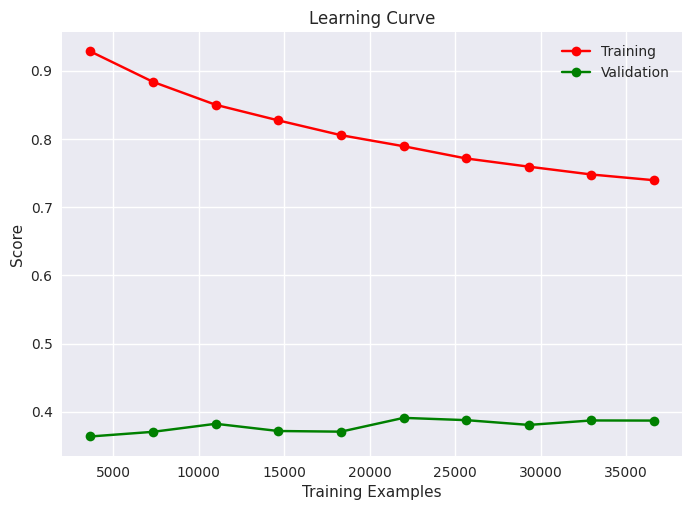

In [22]:
lbfgs_l2 = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'lbfgs', 'l2', True)

## A Library for Large Linear Classification Solver (liblinear) & L1 | L2 Regularization 

LIBLINEAR & L1 Regularization
	Time Taken: 2.39 
	Precision: 0.3824200452537594
	Recall: 0.37993994884124316
	F1-Score: 0.37102502401966897
	Accuracy: 0.37996807778209984



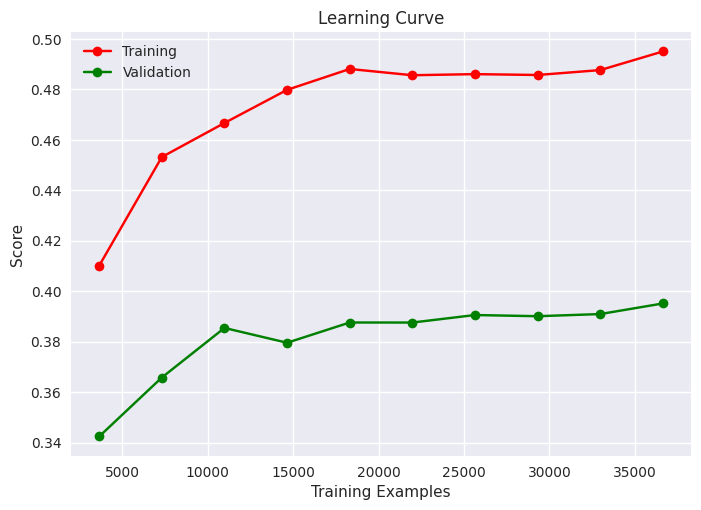

LIBLINEAR & L2 Regularization
	Time Taken: 3.71 
	Precision: 0.3852254088867696
	Recall: 0.38494329721481185
	F1-Score: 0.3845701036814156
	Accuracy: 0.38494177117175354



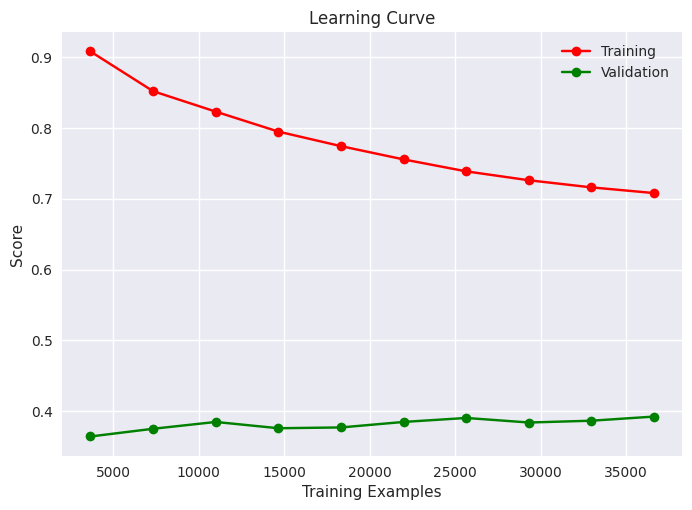

In [23]:
liblinear_l1 = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'liblinear', 'l1', True)
liblinear_l2 = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'liblinear', 'l2', True)

## Newton Conjugate Gradient Solver (newton-cg) & L2 Regularization 

NEWTON-CG & L2 Regularization
	Time Taken: 6.48 
	Precision: 0.38845740153287184
	Recall: 0.3883789480617857
	F1-Score: 0.3880441034353459
	Accuracy: 0.38838089707276185



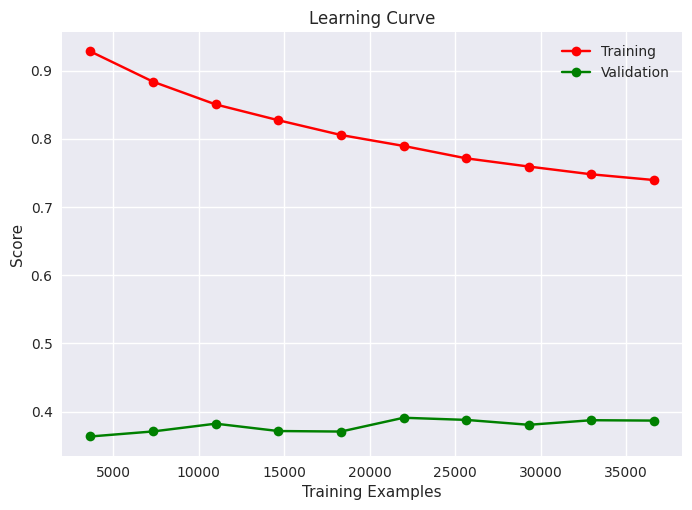

In [24]:
newtoncg_l2 = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'newton-cg', 'l2', True)

## Newton Cholesky Solver (newton-cholesky) & L2 Regularization 
#### Unfortunately, this particular experiment was not possible to complete as it required more than 30GB which is also the limit of the kaggle. <br>Thank you for understanding.

In [25]:
# evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'newton-cholesky', 'l2', True)

## Stochastic Average Gradient Solver (sag) & L2 Regularization 

SAG & L2 Regularization
	Time Taken: 2.94 
	Precision: 0.38845740153287184
	Recall: 0.3883789480617857
	F1-Score: 0.3880441034353459
	Accuracy: 0.38838089707276185



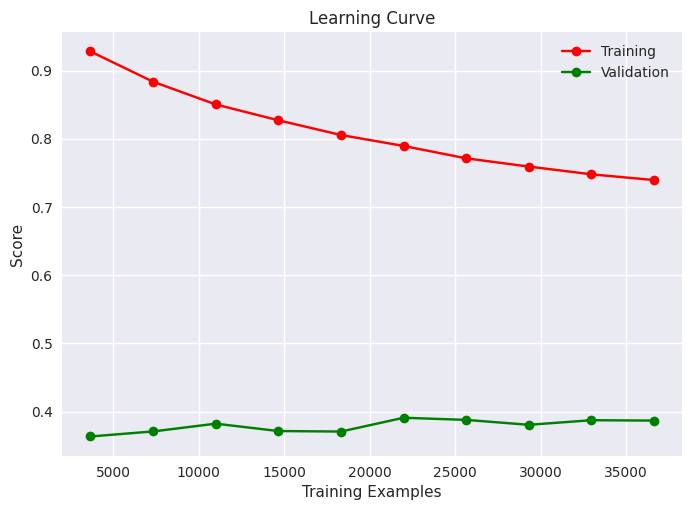

In [26]:
sag_l2 = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'sag', 'l2', True)

## Stochastic Average Gradient Accelerated Method Solver (saga) & L1 | L2 | Elasticnet Regularization

SAGA & L1 Regularization
	Time Taken: 27.02 
	Precision: 0.3763672068004341
	Recall: 0.3753570683617122
	F1-Score: 0.3682815337824909
	Accuracy: 0.3753833679400856



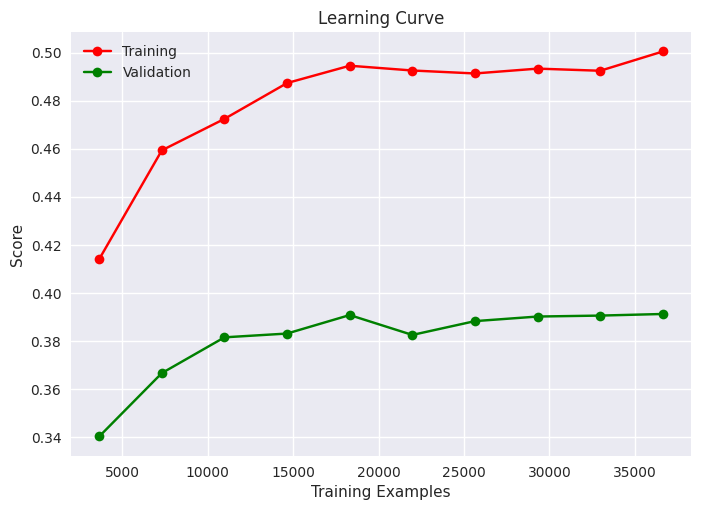

SAGA & L2 Regularization
	Time Taken: 3.14 
	Precision: 0.3880701678461965
	Recall: 0.38799635521303333
	F1-Score: 0.3876750100425387
	Accuracy: 0.3879986705163255



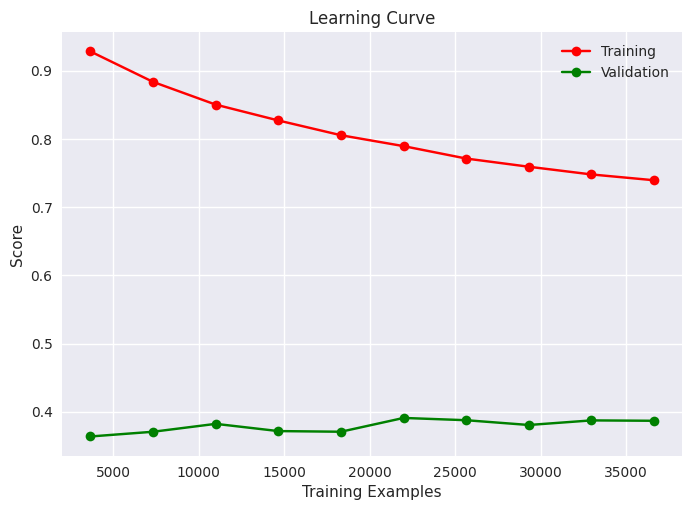

SAGA & ELASTICNET Regularization
	Time Taken: 82.14 
	Precision: 0.37951536294900395
	Recall: 0.3793976221058525
	F1-Score: 0.377604548118815
	Accuracy: 0.3793982990644307



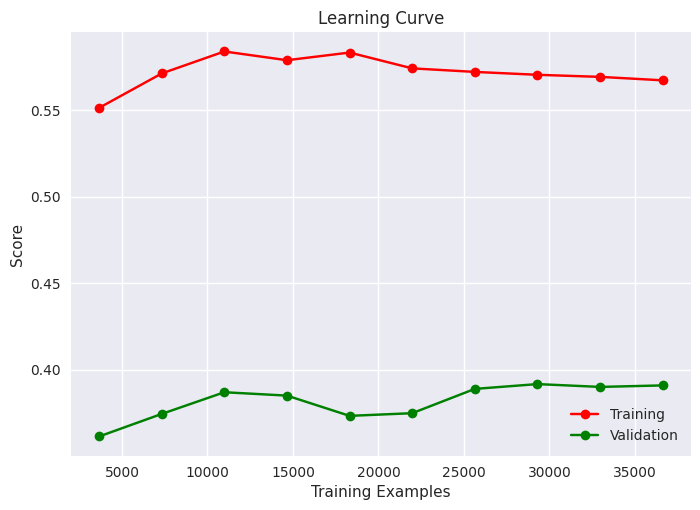

In [27]:
saga_l1 = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'saga', 'l1', True)
saga_l2 = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'saga', 'l2', True)
saga_elasticnet = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'saga', 'elasticnet', True)

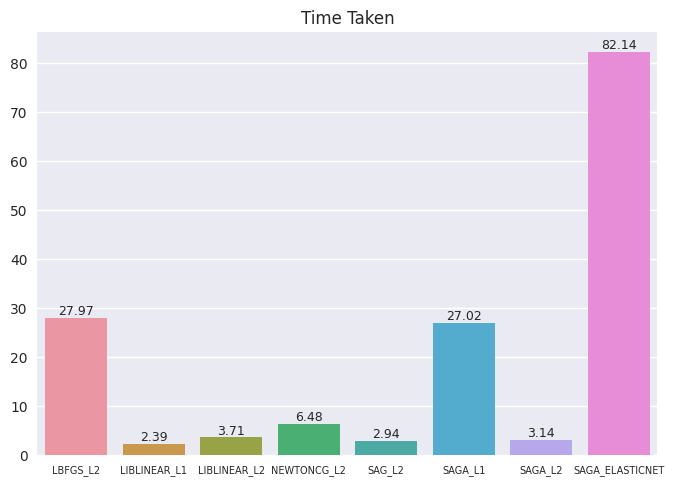

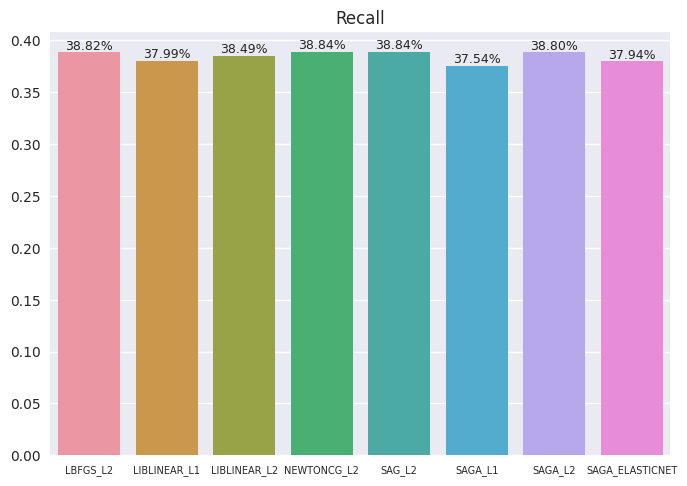

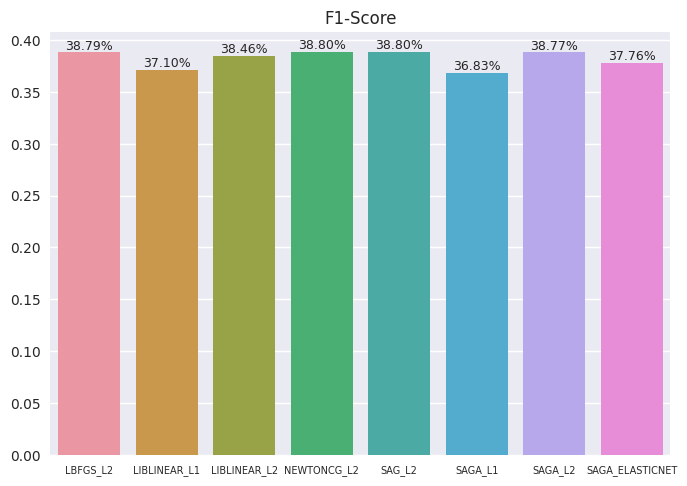

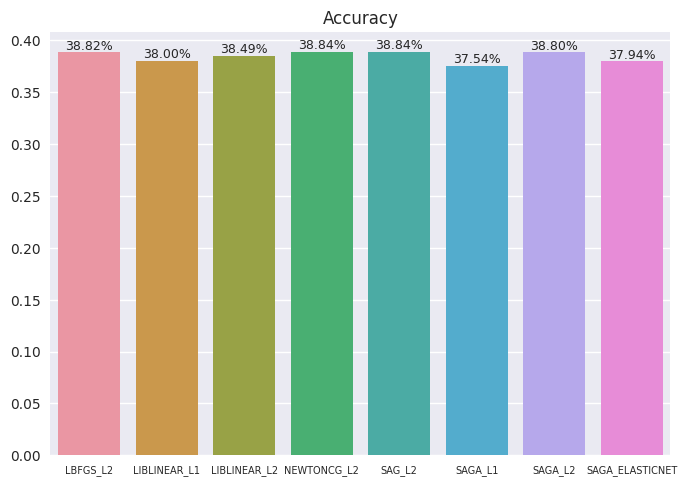

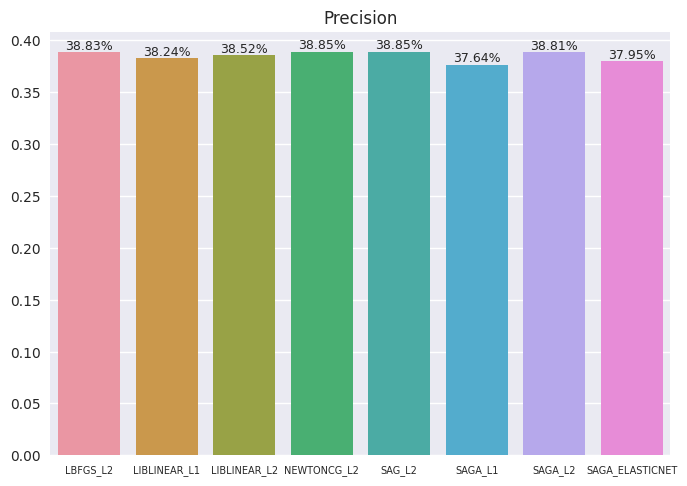

In [28]:
# Define the list with all combinations (unfortunately manually)
combinations = ["lbfgs_l2",
                "liblinear_l1",
                "liblinear_l2",
                "newtoncg_l2",
                "sag_l2",
                "saga_l1",
                "saga_l2",
                "saga_elasticnet"]
# Define the lists that will hold the values for each category 
Time = []
recall = []
f1 = []
accuracy = []
precision = []

for comb in combinations:
    # Now for this combination add its values to the total values in order to plot them
    for i, list_name in enumerate(["Time", "recall", "f1", "accuracy", "precision"]):
        exec(f"{list_name} += [{comb}[{i}]]")

# For every category time, recall etc            
for list_name, title in zip(["Time", "recall", "f1", "accuracy", "precision"],["Time Taken", "Recall", "F1-Score", "Accuracy", "Precision"]):
    # Call a custom bar chart function
    exec(f"bar_chart([float(val) for val in {list_name}], True, \"{title}\", [comb.upper() for comb in combinations])")

## Analysis
Because all of the tested models are overfitting I'm going to use a GridSearchCV in order to test the `C` parameter as well.

In [29]:
df_train_bp = pd.read_json(OUTPUT_PATH + "cleaned_train_bp.json")
df_val_bp = pd.read_json(OUTPUT_PATH + "cleaned_val_bp.json")

In [30]:
X_train = df_train_bp['Text']
X_val = df_val_bp['Text']
Y_train = df_train_bp['Sentiment']
Y_val = df_val_bp['Sentiment']

# Define logistic regression classifier
clf = LogisticRegression(max_iter=2000, random_state=212)

# Define TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform the text data using TF-IDF vectorizer
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)

# Define the hyperparameters and their possible values
param_grid = [    
    {'C': [0.0001, 0.001, 0.01, 0.1, 1], 'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
    {'C': [0.0001, 0.001, 0.01, 0.1, 1], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']},
    {'C': [0.0001, 0.001, 0.01, 0.1, 1], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.5]}
]

# Define scoring
scoring = {
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1-score': make_scorer(f1_score, average='macro', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0)
}

# Create a grid search object with multiple scoring metrics and refit='f1-score'
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=scoring, refit='f1-score')

# Fit the grid search to the TF-IDF transformed training data
grid_search.fit(X_train_vect, Y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=2000, random_state=212),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1], 'penalty': ['l1'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.0001, 0.001, 0.01, 0.1, 1], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag',
                                     'saga']},
                         {'C': [0.0001, 0.001, 0.01, 0.1, 1], 'l1_ratio': [0.5],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             refit='f1-score',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1-score': make_scorer(f1_score, average=macro, zero_division=0),
                      'precision': make_scorer(precision_score, average=macro, zero_division=0),
                      'recall': make_scorer(recall_score, average=macro, zero_division=0)})

In [31]:
df = pd.DataFrame(grid_search.cv_results_)
df_sorted = df.sort_values(by='rank_test_f1-score')
display(df_sorted.loc[:, ['params', 'split0_test_f1-score', 'split1_test_f1-score', 'split2_test_f1-score', 'split3_test_f1-score', 'split4_test_f1-score', 'mean_test_f1-score', 'std_test_f1-score', 'rank_test_f1-score' ]])

,params,split0_test_f1-score,split1_test_f1-score,split2_test_f1-score,split3_test_f1-score,split4_test_f1-score,mean_test_f1-score,std_test_f1-score,rank_test_f1-score
31,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.380189,0.385470,0.377655,0.390874,0.376367,0.382111,0.005378,1
39,"{'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticn...",0.381168,0.380456,0.376790,0.392657,0.379192,0.382052,0.005507,2
16,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.384108,0.374924,0.383045,0.390573,0.374524,0.381435,0.006056,3
25,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.381154,0.378171,0.379918,0.390051,0.375455,0.380950,0.004937,4
10,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}",0.384821,0.373439,0.382153,0.389819,0.374129,0.380872,0.006293,5
12,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'newt...",0.384675,0.372999,0.381905,0.389914,0.374797,0.380858,0.006264,6
18,"{'C': 0.001, 'penalty': 'l2', 'solver': 'sag'}",0.383099,0.374094,0.381716,0.388749,0.376330,0.380798,0.005182,7
27,"{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-...",0.381170,0.378169,0.380057,0.389782,0.374724,0.380781,0.005004,8
17,"{'C': 0.001, 'penalty': 'l2', 'solver': 'newto...",0.383273,0.373491,0.381917,0.390466,0.374594,0.380748,0.006208,9
29,"{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",0.381027,0.378310,0.379793,0.389886,0.374724,0.380748,0.005035,10


## Further Analysis
We will try using the top model for each C category that does not have the default `C` value in order for us to check if they are overfitting again.

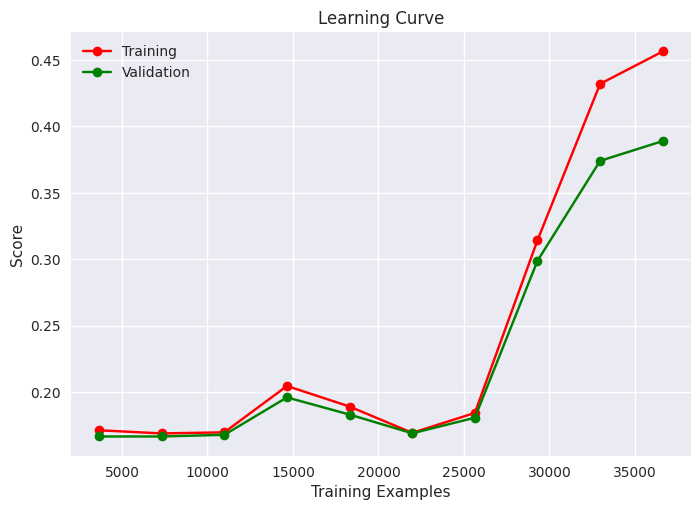

In [32]:
liblinear_l2_new_c = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'liblinear', 'l2', False, 0.001)

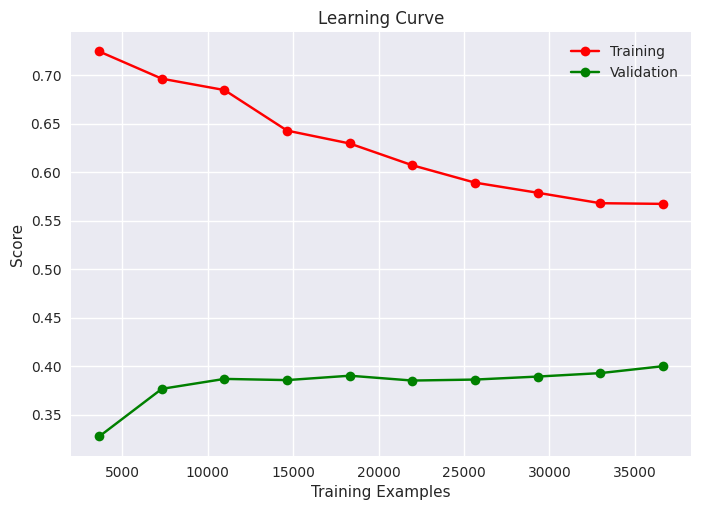

In [33]:
lbfgs_l2_new_c = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'lbfgs', 'l2', False, 0.1)

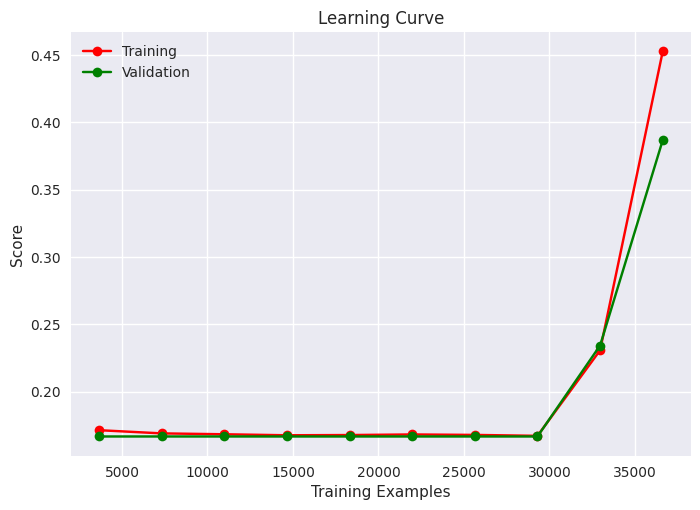

In [34]:
lbfgs_l2_new_c_2 = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'lbfgs', 'l2', False, 0.0001)

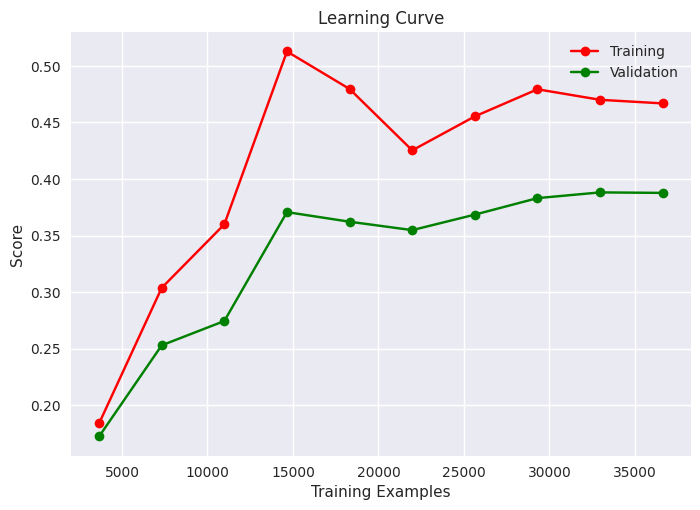

In [35]:
liblinear_l2_new_c_2 = evaluate_solvers_regularizers(df_train_bp, df_val_bp, 'liblinear', 'l2', False, 0.01)

## Best Model Selection
As we can see from the above, the overfitting was eliminated and the best model consists of the following:
* TF-IDF Vectorizer
* C = 0.001
* solver = liblinear
* penalty = l2

# Evaluation on Test Set
In order to make things easier you can run only the cell below and it will include everything you need for the following:
* You can make predictions in unseen data without scores
* You can make evaluation with the labels

In [36]:
import csv
import string
import time

import numpy as np
import pandas as pd
# We changing the default settings because with the default we were not able to read any tweets
pd.set_option('display.max_colwidth', 300) 


import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

import unicodedata
from unidecode import unidecode

import spacy
!python -m spacy download el_core_news_lg --quiet
nlp = spacy.load("el_core_news_lg")

########################################################################################

def custom_roc_curve(Y_val, y_score, classes, show):
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i, label in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(Y_val == label, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve {classes[i]} (AUC = {roc_auc[i]*100:0.2f}%)')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    if show:
        plt.show()

def custom_learning_curve(train_score, test_score, size, show):
    plt.title("Learning Curve")
    plt.plot(size, train_score, 'o-', color="r", label="Training")
    plt.plot(size, test_score, 'o-', color="g", label="Validation")
    plt.legend(loc="best")
    plt.ylabel("Score")
    plt.xlabel("Training Examples")
    if show:
        plt.show()

def custom_confusion_matrix(conf_matrix, classes, show):
    # Generate and print confusion matrix  
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = classes)
    cm_display.plot(ax=plt.gca())
    plt.grid(False)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.title("Confusion Matrix")
    if show:
        plt.show()

########################################################################################

ROOT_PATH = "/kaggle/"
INPUT_PATH = ROOT_PATH + "input/ys19-2023-assignment-1/"
OUTPUT_PATH = ROOT_PATH + "working/"

########################################################################################

def remove_accents(word):
    ret =''.join(c for c in unicodedata.normalize('NFD', word) if unicodedata.category(c) != 'Mn')
    return ret

def clean_tweets(df, lemm):
    # That's the basic pre-processing    
    # Remove possible links starting with http/https/www
    df['Text'] = df['Text'].str.replace(r"(http[s]?://|www\.)[^\s]+", " ", regex = True)
    # Remove whole word with # symbol
    df['Text'] = df['Text'].str.replace(r"(#)[^\s]+", " ", regex = True)
    # Remove whole word with @ symbol
    df['Text'] = df['Text'].str.replace(r"(@)[^\s]+", " ", regex = True)
    # Lowercase everything
    df['Text'] = df['Text'].str.lower()
    # Keep only latin/greek letters and numbers
    df['Text'] = df['Text'].str.replace(r"[^\wa-zα-ω]", " ", regex = True)  
    # If the user wants to do the lemmazation process we will perform it otherwise the token will be added only if it is not a stop word
    df['Tokens'] = df['Text'].apply(lambda text: [token.lemma_ if lemm else token.text for token in nlp(remove_accents(text)) if token.text not in nlp.Defaults.stop_words and token.text.strip()])
    # At last we are combine the tokens to create the new text for the tweet    
    df['Text'] = df['Tokens'].apply(lambda tokens: " ".join(tokens))
    # Then return the cleaned dataframe
    return df

########################################################################################

for word in set(nlp.Defaults.stop_words):
    nlp.Defaults.stop_words.add(remove_accents(word))
nlp.Defaults.stop_words.add('κ')
nlp.Defaults.stop_words.add('κι')

########################################################################################

def show_score_full(message, t, r, f, a, p):
  # Print the classificaiton method
  print(message)
  # Print Time
  print(f"\tTime Taken: {t} ")
  # Print Precision
  print(f"\tPrecision: {p}")
  # Print Recall
  print(f"\tRecall: {r}")
  # Print F-Measure
  print(f"\tF1-Score: {f}")
  # Print Accuracy
  print(f"\tAccuracy: {a}\n")

########################################################################################

def predict_unseen_data(TRAIN_PATH, TEST_PATH, evaluation):
    # Load the datasets     
    train_set = pd.read_csv(TRAIN_PATH)
    test_set = pd.read_csv(TEST_PATH)
    
    # Next we are going to clean up the datasets based on the choices we made so far
    train_set_cleaned = train_set.copy()
    train_set_cleaned = clean_tweets(train_set_cleaned, False)
    test_set_cleaned = test_set.copy()
    test_set_cleaned = clean_tweets(test_set_cleaned, False)
    
    X_train = train_set_cleaned['Text']
    X_test = test_set_cleaned['Text']
    Y_train = train_set_cleaned['Sentiment']
        
   
    if evaluation:
        Y_test = test_set_cleaned['Sentiment']
        # Begin timer    
        begin_timer = time.perf_counter()

        # Define classifier
        clf = LogisticRegression(max_iter=2000, random_state=212, C=0.001, penalty='l2', solver='liblinear')

        # Define vectorizer 
        vectorizer = TfidfVectorizer()

        # For the train set we !fit_transform!
        X_train_vect = vectorizer.fit_transform(X_train)
        # On ther other hand for the validation set we only !transform!
        X_test_vect = vectorizer.transform(X_test)   
        clf.fit(X_train_vect, np.ravel(Y_train))
        scores = cross_validate(clf, X_test_vect, np.ravel(Y_test), cv=5, n_jobs = -1, scoring=scoring)

        # Stop timer
        stop_timer = time.perf_counter()

        # Calculate Time Taken
        time_taken = f"{stop_timer-begin_timer:.2f}"

        # Split the scores in variables
        recall_scores = scores['test_recall'].mean()
        f1_scores = scores['test_f1-score'].mean()
        accuracy_scores = scores['test_accuracy'].mean()
        precision_scores = scores['test_precision'].mean()
        # Show the results
        show_score_full(f"Best Model:", time_taken, recall_scores, f1_scores, accuracy_scores, precision_scores)

        # We will make a predict for the confusion matrix
        y_predict = clf.predict(X_test_vect)
        # We will make a predict proba for the roc curve 
        y_score = clf.predict_proba(X_test_vect)

        # Now we are going to calculate and plot the learning curve

        # Define the classifier again
        clf = LogisticRegression(max_iter=2000, random_state=212, C=0.001, penalty='l2', solver='liblinear')
        # A list to store the train scores    
        train_scores = []
        # A list to store the validation scores    
        test_scores = []
        # Make a list with 10 numbers which represents the current number of training examples we are going to use for our model
        sizes = (np.linspace(0.1, 1.0, 10)*(X_train.shape[0])).astype(int)
        # For every of that example   
        for size in sizes:
            # Fit the classifier        
            clf.fit(X_train_vect[:size], np.ravel(Y_train[:size]))
            # Make a predicition on train set        
            train_pred = clf.predict(X_train_vect[:size])
            # Make a predicition on validation set
            test_pred = clf.predict(X_test_vect)
            # Store the current train score        
            train_scores += [f1_score(Y_train[:size], train_pred, average="macro")]
            # Store the current validation score
            test_scores += [f1_score(Y_test, test_pred, average="macro")]


        # Make all the plots
        # Define all plots
        all_plots = ["custom_roc_curve(Y_val, y_score, clf.classes_, False)",
                     "custom_learning_curve(train_scores, test_scores, sizes, False)",
                     "custom_confusion_matrix(confusion_matrix(Y_val, y_predict, normalize='true'), clf.classes_, False)"]
        # Make subplots
        fig, axes = plt.subplots(1, len(all_plots), figsize=(15, 5))
        # Print each plot in a different subplot section
        for i, plot_command in enumerate(all_plots):
            plt.subplot(1, len(all_plots), i + 1)
            exec(f"{plot_command}")
        plt.tight_layout()
        plt.show()
    else:
        # Define classifier
        clf = LogisticRegression(max_iter=2000, random_state=212, C=0.001, penalty='l2', solver='liblinear')

        # Define vectorizer 
        vectorizer = TfidfVectorizer()

        # For the train set we !fit_transform!
        X_train_vect = vectorizer.fit_transform(X_train)
        # On ther other hand for the validation set we only !transform!
        X_test_vect = vectorizer.transform(X_test)   
        clf.fit(X_train_vect, np.ravel(Y_train))
        
        test_predictions = clf.predict(X_test_vect)

        df_test = pd.DataFrame(list(enumerate(test_predictions, start=1)), columns=["Id", "Predicted"])
        df_test.to_csv(OUTPUT_PATH + "submission.csv", index=False)
        
        print("Sentiment Classification is done!")
        print("You can find the results in the submission.csv")

✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_lg')


That's the results for the test set which also shows the work of the function

In [37]:
predict_unseen_data(INPUT_PATH + "train_set.csv", INPUT_PATH + "test_set.csv", False)

Sentiment Classification is done!
You can find the results in the submission.csv


That's the results for the validation set as before just to show that it works for evaluation as well and make the plots for the report

Best Model:
	Time Taken: 3.70 
	Precision: 0.3887267312255672
	Recall: 0.3844635466411971
	F1-Score: 0.3778712561197638
	Accuracy: 0.3843646875987297



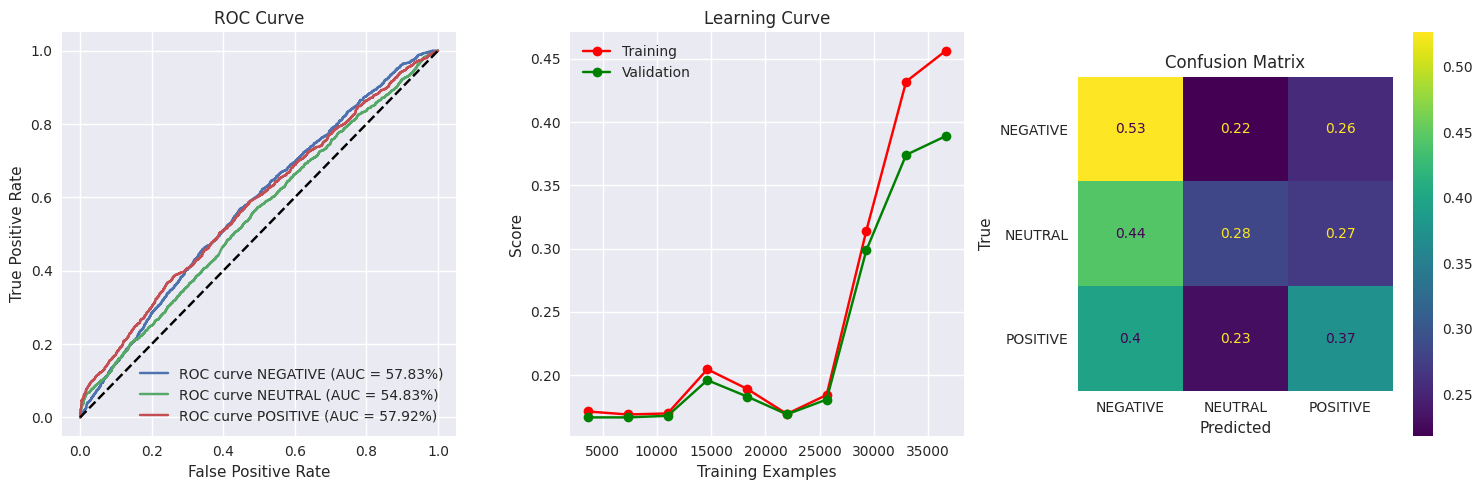

In [38]:
predict_unseen_data(INPUT_PATH + "train_set.csv", INPUT_PATH + "valid_set.csv", True)